In [1]:
%matplotlib inline

from subprocess import Popen, PIPE, CalledProcessError
import re
import ipywidgets as widgets
import time
import getpass
from encrypt import decryptCredentials,decryptString
import psycopg2 as db
from psycopg2.extensions import AsIs
from psycopg2.extras import execute_values 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import xarray as xr
from shapely.wkb import loads
from shapely.geometry.polygon import Polygon
from shapely.geometry.point import Point
from shapely.ops import cascaded_union

# import plotly.plotly as py
# import plotly.tools as tools
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.shapereader as shpreader

import os.path
from functools import partial

from IPython.display import HTML

# tools.set_credentials_file(username='calidonio', api_key='LqhUF9UtPewuw65GDmzO')

# init_notebook_mode()

## Getting polygon for basin

In [2]:
token = b'gAAAAABayyyn8ZnEstm8ZQqClUYQ-IqFFuMO4QTbmFJADHWBAcirh52s5stDwSwtVK7qVm5tzdTNFxTQjuRF28b1t2rosFSl_nnTowWrD4itOjkzF7s6Kg_qa1Adqpj59OAfBapgkToUQUHvEFY1Njc4he36AC76gmb8t0CJCq4ze2pDHWIlGdDacZxQ1jq14uLVxrFfCTSxDPX8Mx9W1av723etkOdWvw=='
key = getpass.getpass('Password: ')
credentials = decryptCredentials(token,key)

# Testing connection to database
try : 
    conn = db.connect("dbname={} user={} host={} password={}".format(credentials['database'],credentials['username'],credentials['host'],credentials['password']))
    print('Connection successful!')
except :
    print("Unable to connect")
    
conn.close()  

Password: ········
Connection successful!


(4358465.77233919, 4386543.27233919, 4024442.10566967, 4087444.60566967)

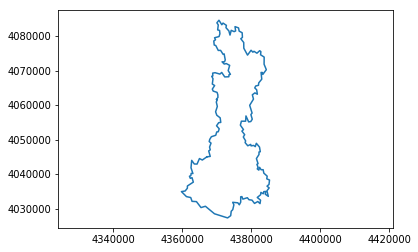

In [3]:
getBox=True
if getBox:
    basinSchema='basins'
    conn = db.connect("dbname={} user={} host={} password={}".format(credentials['database'],
                                                                           credentials['username'],
                                                                            credentials['host'],
                                                                            credentials['password']
                                                                          )
                           )
    #And a test query
    cursor = conn.cursor()

    cursor.execute('''SELECT ST_Simplify(a.basin,250) FROM %(tableSHP)s AS a;'''
                      ,{"tableSHP": AsIs(basinSchema+'.resultsShp')}
                  )

    box = cursor.fetchone()
    
    conn.close()

basin = loads(box[0], hex=True)
basin = cascaded_union(basin)
x,y = basin.exterior.xy
plt.plot(x,y)
plt.axis('equal')

In [4]:
conn.close()

# Uploading gridded dataset to database and getting areal average


In [5]:
nc_file='./rain.nc4'
nc_data = xr.open_dataset(nc_file)

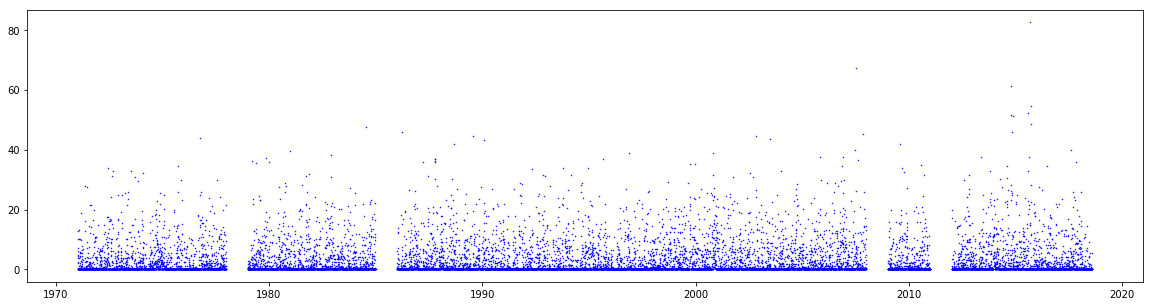

In [6]:
rain = nc_data.RR #-273.15
rain1d = rain.isel(X=25, Y=57)
time=nc_data.time
plt.figure(figsize=(20,5))
plt.plot(time,rain1d,'b.',markersize=1)


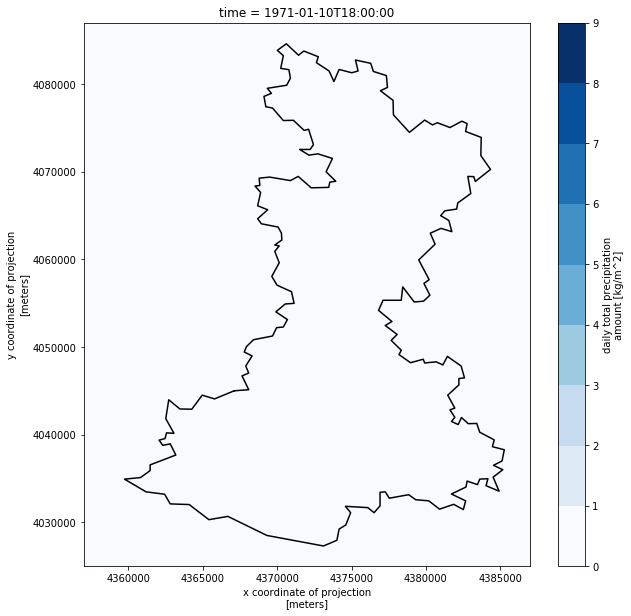

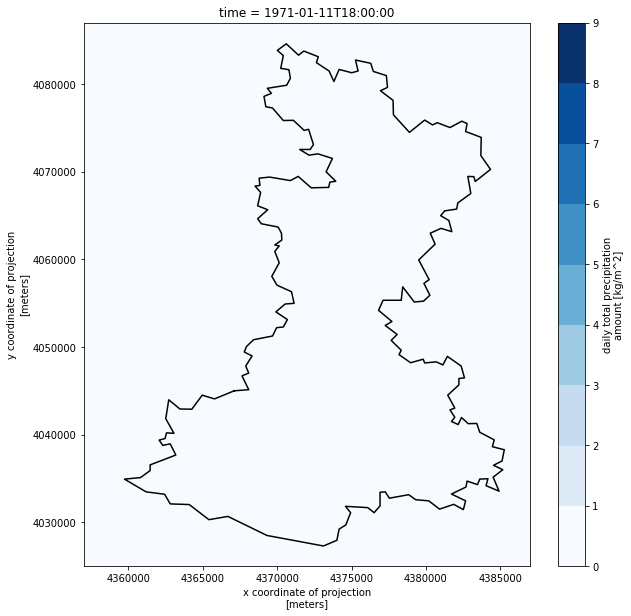

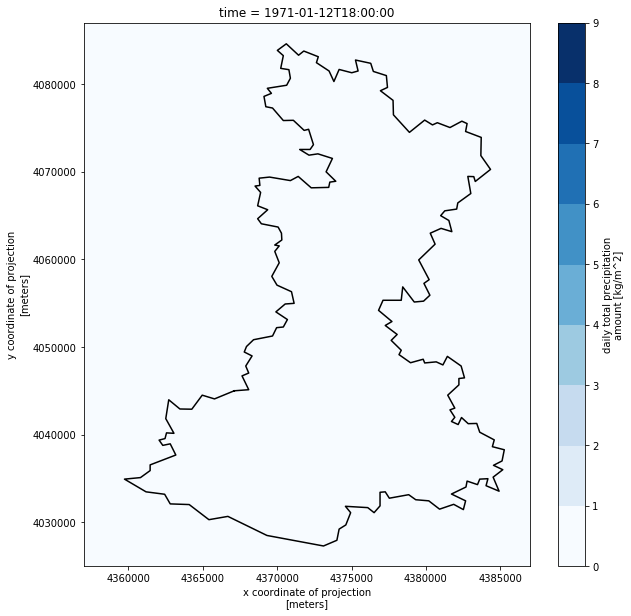

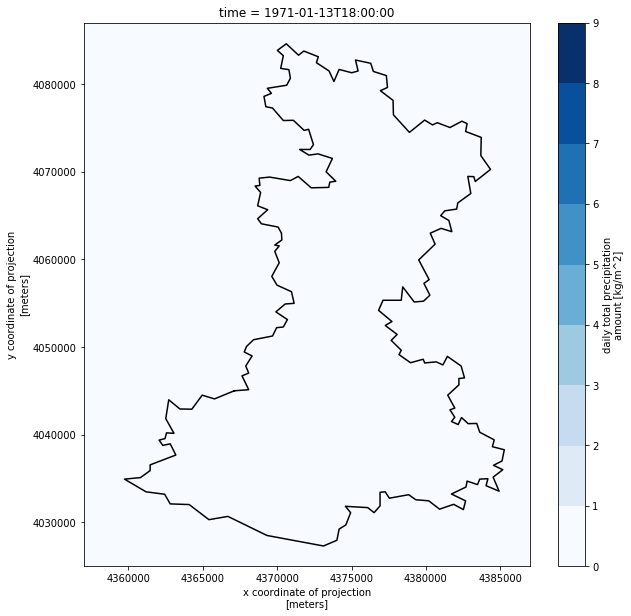

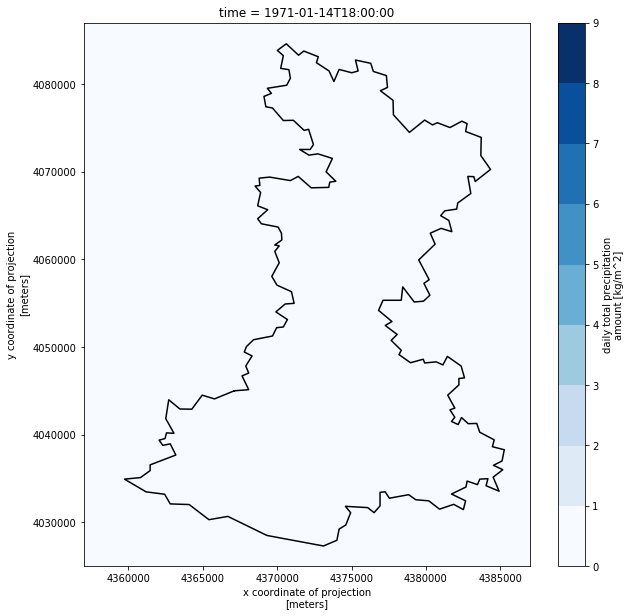

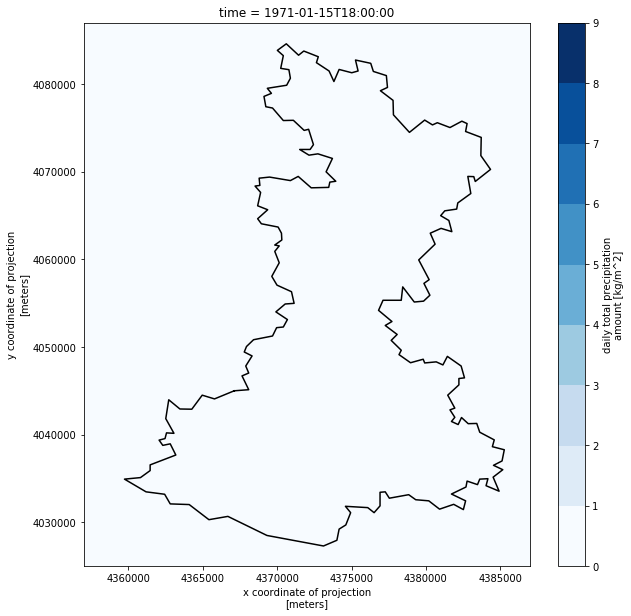

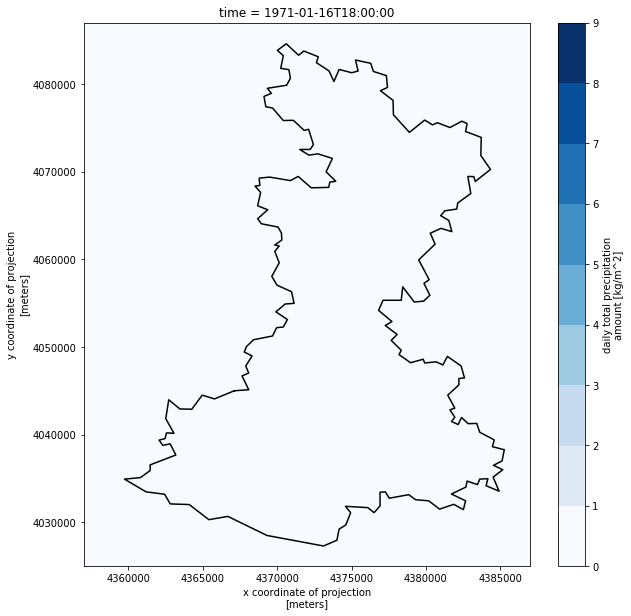

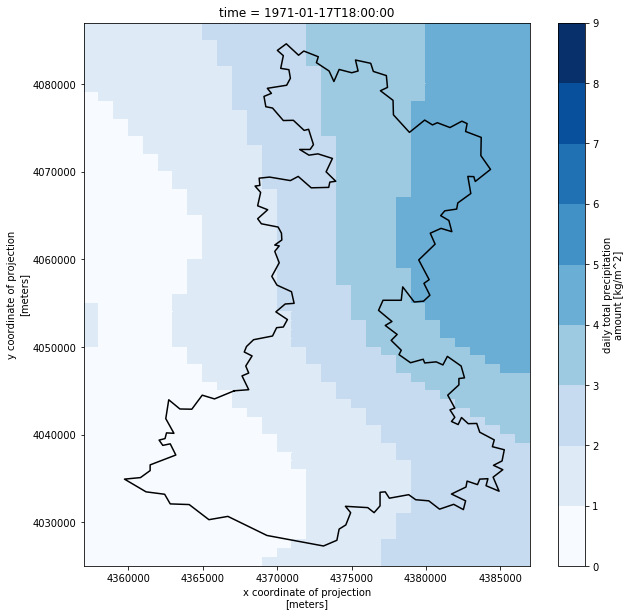

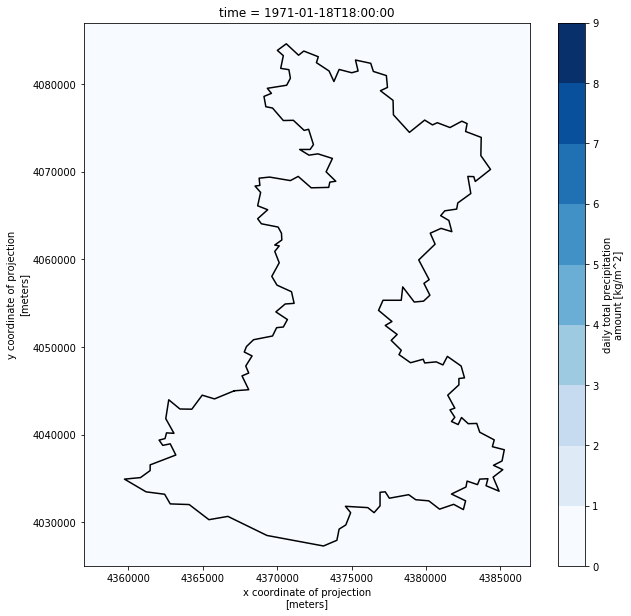

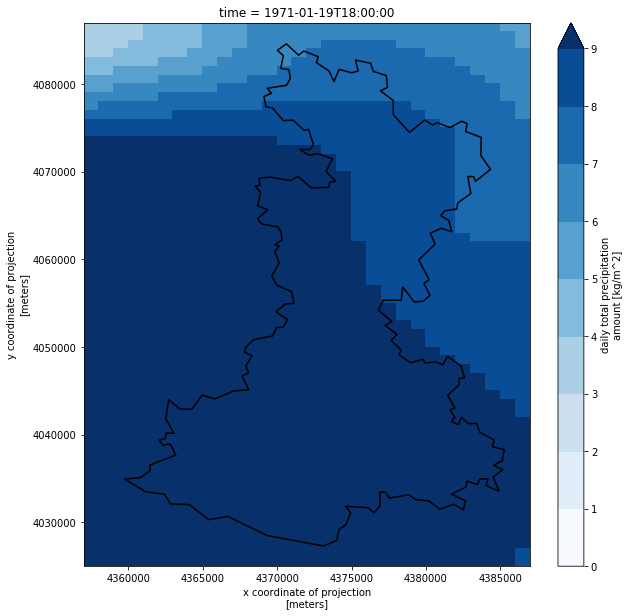

In [7]:
rng = [float(x) for x in range(10)]

for i in range(10):
    rain2d = rain.isel(time=i)
    plt.figure(figsize=(10,10))
    rain2d.plot(levels=rng,cmap=plt.cm.Blues)
    plt.plot(x,y,'k-')
    
nc_data.close()    

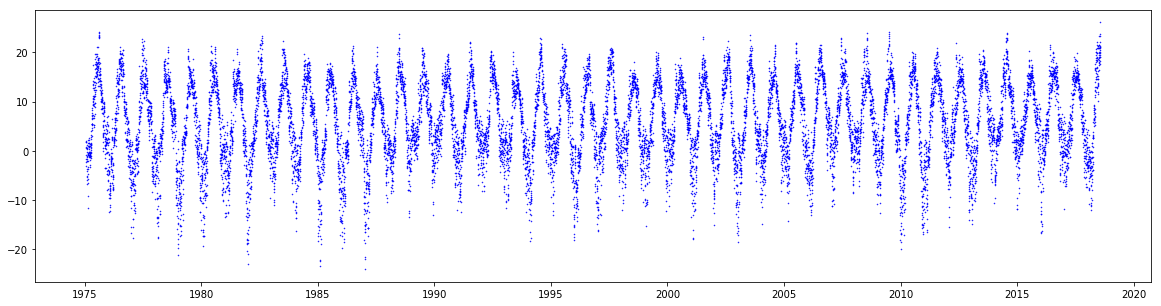

In [8]:
nc_file='./temperature.nc4'
nc_data = xr.open_dataset(nc_file)
air = nc_data.TG - 273.15
time=nc_data.time
air1d = air.isel(X=25, Y=57)
plt.figure(figsize=(20,5))
plt.plot(time,air1d,'b.',markersize=1)

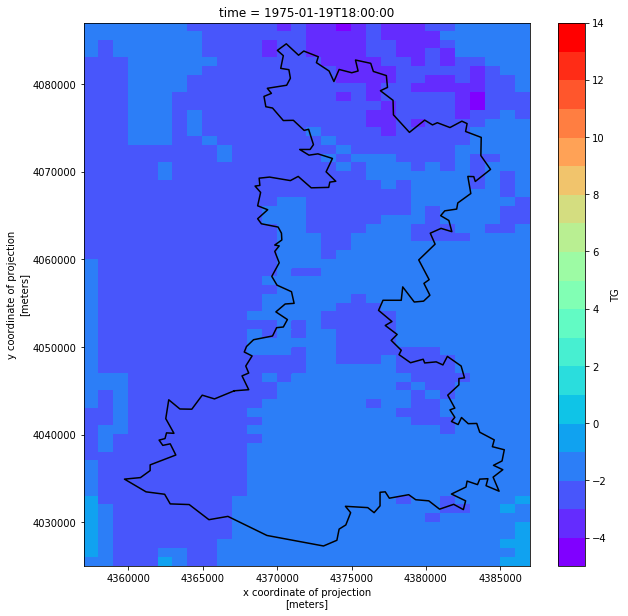

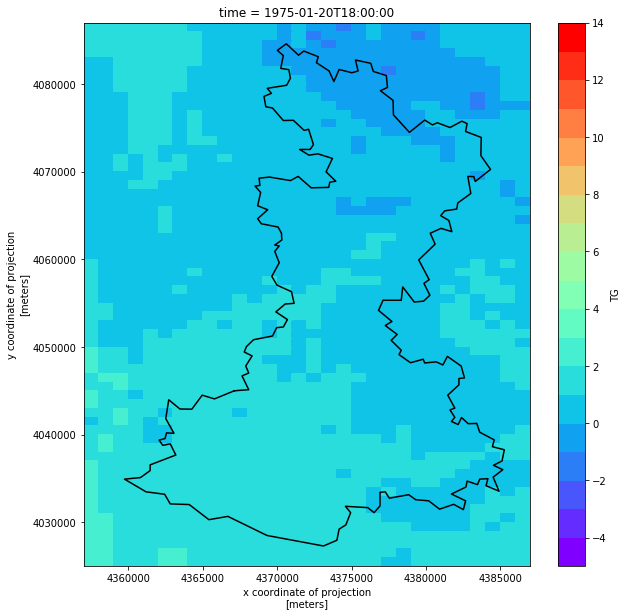

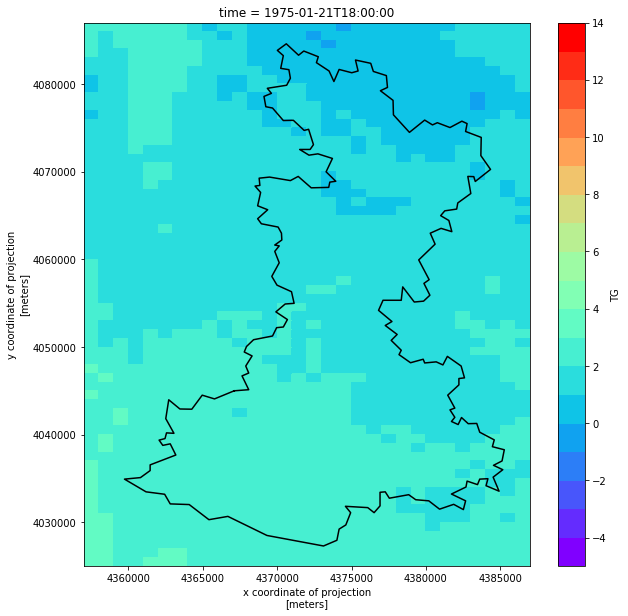

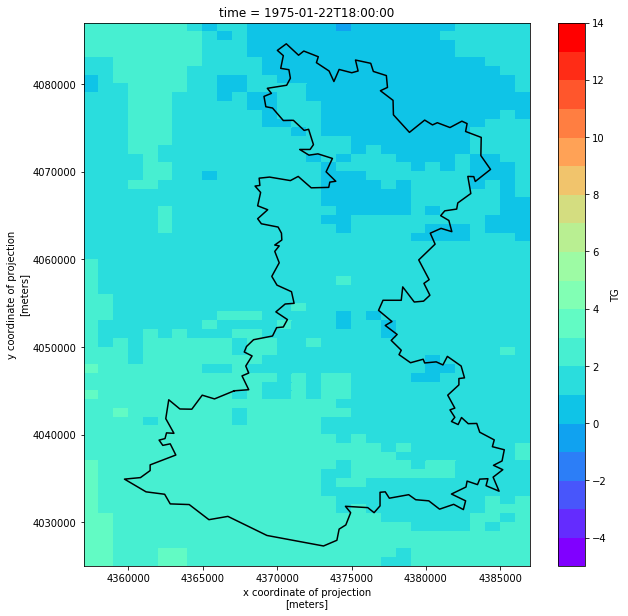

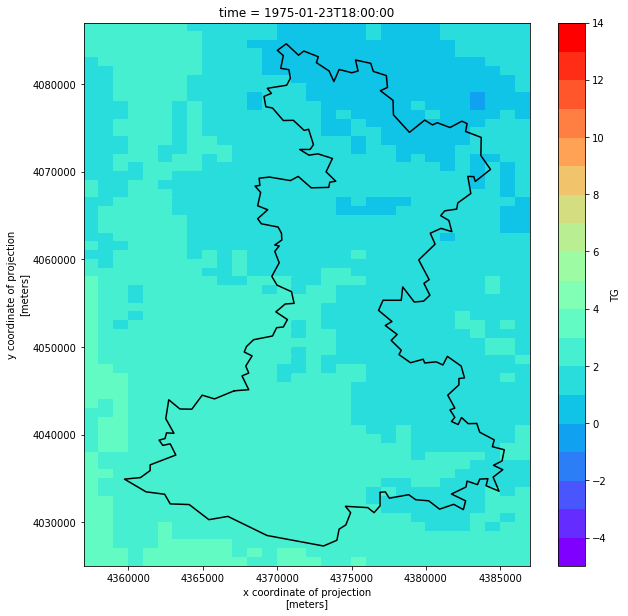

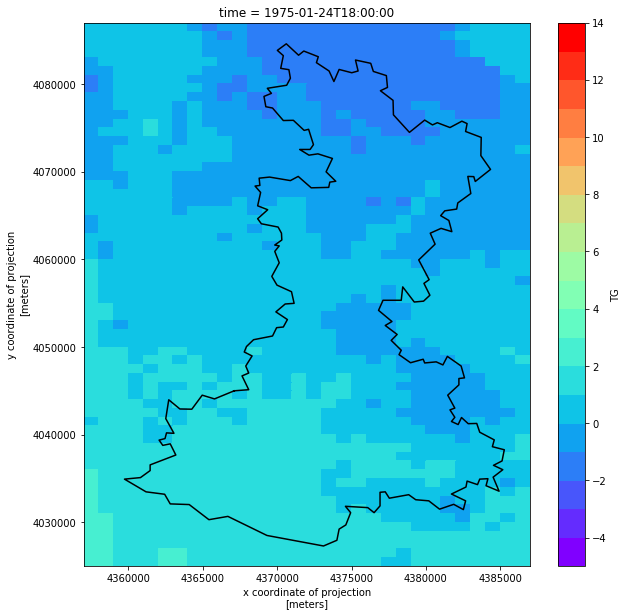

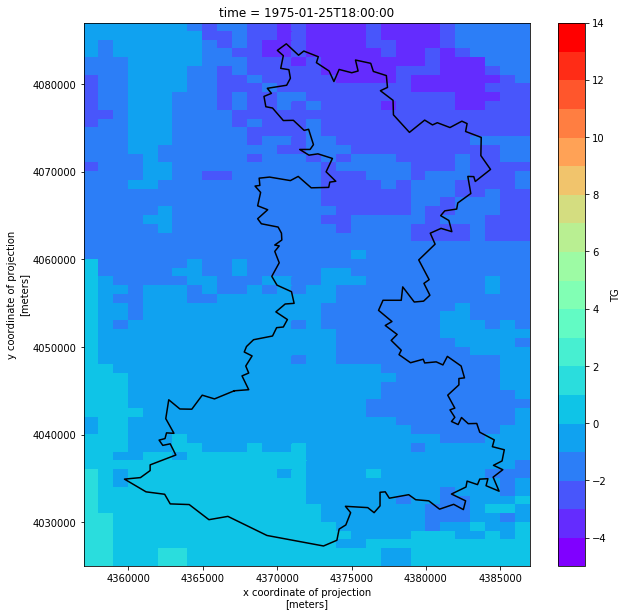

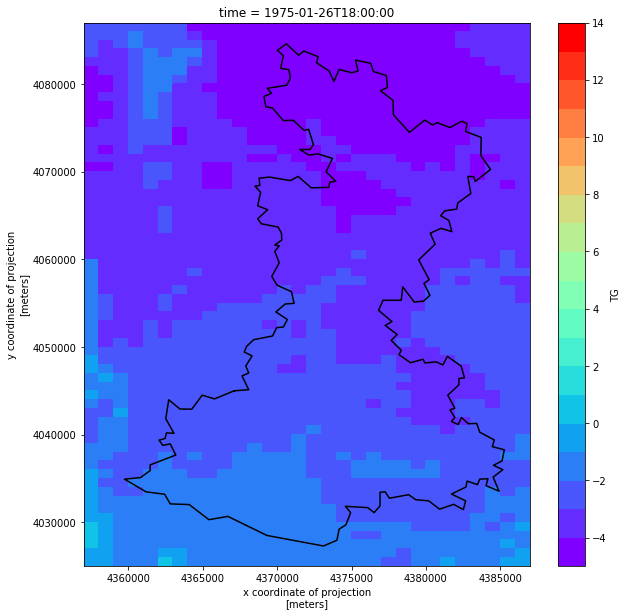

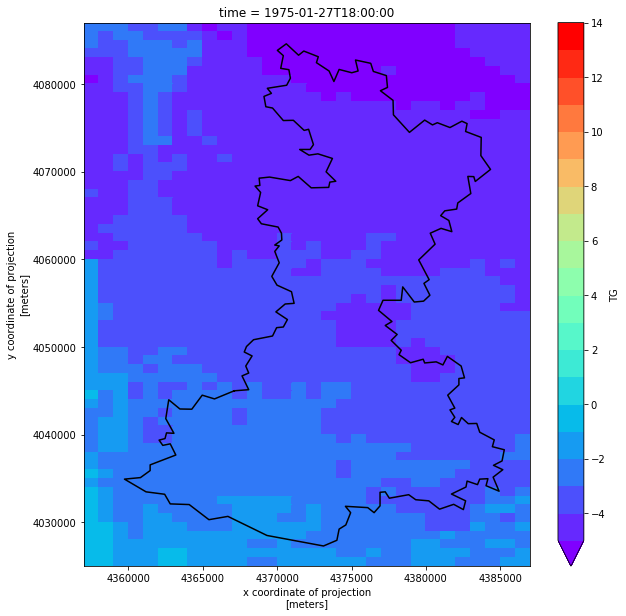

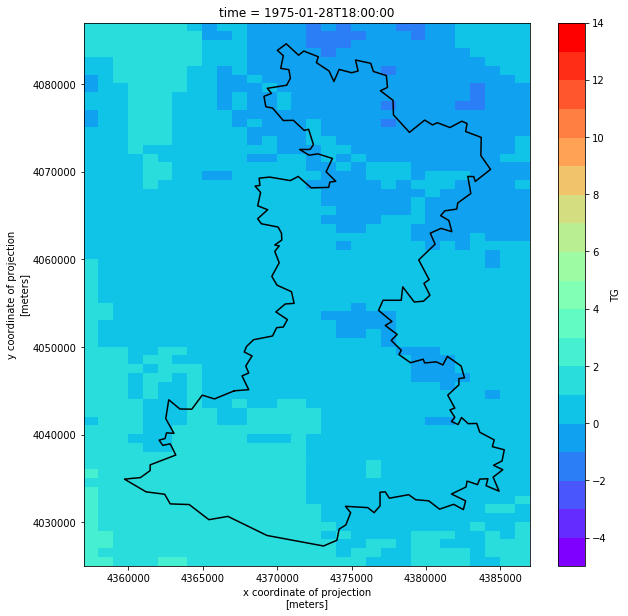

In [9]:
rng = [float(x) for x in range(-5,15)]
for i in range(10):
    air2d = air.isel(time=i)
    plt.figure(figsize=(10,10))
    air2d.plot(levels=rng,cmap=plt.cm.rainbow)
    plt.plot(x,y,'k-')
nc_data.close()

In [10]:

def make_figure():
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.epsg(3035))
    # generate a basemap with country borders, oceans and coastlines
    #ax.add_feature(cfeat.LAND)
    #ax.add_feature(cfeat.OCEAN)
    #ax.add_feature(cfeat.COASTLINE)
    #ax.add_feature(cfeat.BORDERS, linestyle='dotted')
    #ax.add_feature(cfeat.RIVERS)
    ax.add_geometries([basin,],crs=ccrs.epsg(3035),edgecolor='black', facecolor='none')
    ax.set_extent((4358465.77233919, 4386543.27233919, 4024442.10566967, 4087444.60566967), crs=ccrs.epsg(3035))
    return fig, ax

def draw(frame, add_colorbar,nc_data,variable):
    grid = variable[frame]
    contour = grid.plot(ax=ax, transform=ccrs.epsg(3035),
                        add_colorbar=add_colorbar, vmin=min_value, vmax=max_value, cmap=cmap)
    title = u"%s — %s" % (variable.long_name, str(nc_data.time[frame].values)[:19])
    ax.set_title(title)
    return contour


def init(nc_data,variable):
    return draw(0, True,nc_data,variable)


def animate(frame,nc_data,variable):
    if((frame % 100)==False):
        print(frame)
    return draw(frame, False,nc_data, variable)



fig, ax = make_figure()

nc_file='./temperature.nc4'
nc_data = xr.open_dataset(nc_file)
frames = 366
min_value = -5.  # Lowest value
max_value = 20.  # Highest value
cmap='jet'

videoFile='temp.mp4'
ncFile=nc_data
nc_data.TG.values -= 273.15
animate_temp = partial(animate,nc_data=nc_data,variable=nc_data.TG)
init_temp = partial(init,nc_data=nc_data,variable=nc_data.TG)

if (not os.path.isfile(videoFile)):
    ani = animation.FuncAnimation(fig, animate_temp, frames, interval=0.01, blit=False,
                                  init_func=init_temp, repeat=False)
    ani.save(videoFile, writer=animation.FFMpegWriter(fps=10))


plt.close(fig)
nc_data.close()


fig, ax = make_figure()
nc_file='./rain.nc4'
nc_data = xr.open_dataset(nc_file)
frames = 366 #air.time.size        # Number of frames
min_value = 0.  # Lowest value
max_value = 15.  # Highest value
cmap=cm.get_cmap('Blues')
# cmap='Blues_r'

videoFile='rain.mp4'
ncFile=nc_data
animate_rain = partial(animate,nc_data=nc_data,variable=nc_data.RR)
init_rain = partial(init,nc_data=nc_data,variable=nc_data.RR)

if (not os.path.isfile(videoFile)):
    ani = animation.FuncAnimation(fig, animate_rain, frames, interval=0.01, blit=False,
                                  init_func=init_rain, repeat=False)
    ani.save(videoFile, writer=animation.FFMpegWriter(fps=10))
  
plt.close(fig)    
nc_data.close()

In [11]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="./temp.mp4" type="video/mp4">
</video></div>""")

In [12]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="./rain.mp4" type="video/mp4">
</video></div>""")

## Uploading to database to get basin average
### Getting boundaries  and intersection with basin for all raster cells


In [17]:
boundaries=[]
nc_file='./temperature.nc4'
nc_data = xr.open_dataset(nc_file)
for i in nc_data.X.values:
    for j in nc_data.Y.values:
        left=i-500
        right=i+500
        bottom=j-500
        top=j+500
        p1 = Point(left,bottom)
        p2 = Point(left,top)
        p3 = Point(right,top)
        p4 = Point(right,bottom)
        pointList = [p1, p2, p3, p4, p1]
        poly = Polygon([[p.x, p.y] for p in pointList])
        boundaries.append((poly.wkb_hex,np.nan))
        

nc.close()    


basinSchema='basins'
conn = db.connect("dbname={} user={} host={} password={}".format(credentials['database'],
                                                                       credentials['username'],
                                                                        credentials['host'],
                                                                        credentials['password']
                                                                      )
                       )
#And a test query
cursor = conn.cursor()

cursor.execute('''DROP TABLE IF EXISTS %(schema)s.%(table)s;
                  CREATE TABLE %(schema)s.%(table)s (sid SERIAL PRIMARY KEY,
                                                     boundary geometry(POLYGON,0),
                                                     prcIntersection DOUBLE PRECISION                                                   
                                                     );
               '''
                  ,{"schema": AsIs(basinSchema), "table": AsIs("dataBoundaries")}
              )
conn.commit()
execute_values(cursor,'''
                      INSERT INTO basins.dataBoundaries(boundary,prcIntersection) VALUES %s;
                      ''', boundaries
              )

conn.commit()

cursor.execute('''ALTER TABLE %(schema)s.%(table)s
                  ALTER COLUMN boundary TYPE geometry(POLYGON, 3035)
                  USING ST_SetSRID(boundary,3035);'''
               ,{"schema": AsIs(basinSchema), "table": AsIs("dataBoundaries")}
              )
conn.commit()


cursor.execute('''CREATE INDEX data_boundary_gix ON %(schema)s.%(table)s USING GIST (boundary)'''
               ,{"schema": AsIs(basinSchema), "table": AsIs("dataBoundaries")}
              )
conn.commit()

cursor.execute('''UPDATE %(schema)s.%(table)s AS a
                  SET prcIntersection = (ST_Area(ST_Intersection(a.boundary,b.basin)))
                  FROM basins.resultsShp AS b
                  WHERE b.sid=1 AND ST_Intersects(a.boundary,b.basin); 
                  ;'''
               ,{"schema": AsIs(basinSchema), "table": AsIs("dataBoundaries")}
              )
conn.commit()
              
#Getting results
cursor.execute('''SELECT a.sid,a.prcIntersection FROM %(schema)s.%(table)s AS a; 
               '''
               ,{"schema": AsIs(basinSchema), "table": AsIs("dataBoundaries")}
              )
conn.commit()

weights=cursor.fetchall()
weights = [(i[0],i[1]) for i in weights]

print(weights)
    
    
conn.close()

[(1, nan), (2, nan), (3, nan), (4, nan), (5, nan), (6, nan), (7, nan), (8, nan), (9, nan), (10, nan), (11, nan), (12, nan), (13, nan), (14, nan), (15, nan), (16, nan), (17, nan), (18, nan), (19, nan), (20, nan), (21, nan), (22, nan), (23, nan), (24, nan), (25, nan), (26, nan), (27, nan), (28, nan), (29, nan), (30, nan), (31, nan), (32, nan), (33, nan), (34, nan), (35, nan), (36, nan), (37, nan), (38, nan), (39, nan), (40, nan), (41, nan), (42, nan), (43, nan), (44, nan), (45, nan), (46, nan), (47, nan), (48, nan), (49, nan), (50, nan), (51, nan), (52, nan), (53, nan), (54, nan), (55, nan), (56, nan), (57, nan), (58, nan), (59, nan), (60, nan), (61, nan), (62, nan), (63, nan), (64, nan), (65, nan), (66, nan), (67, nan), (68, nan), (69, nan), (70, nan), (71, nan), (72, nan), (73, nan), (74, nan), (75, nan), (76, nan), (77, nan), (78, nan), (79, nan), (80, nan), (81, nan), (82, nan), (83, nan), (84, nan), (85, nan), (86, nan), (87, nan), (88, nan), (89, nan), (90, nan), (91, nan), (92, na

### Applying weights

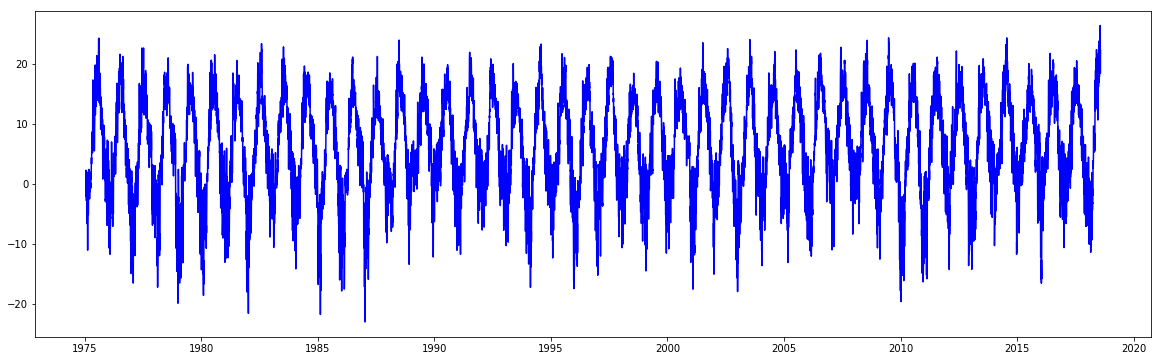

In [44]:
nc_file='./temperature.nc4'
nc_data = xr.open_dataset(nc_file)
time = nc_data.time.values
tempData =  nc_data.TG.values - 273.15
nc_data.close()

weightArray = np.array([i[1] for i in weights]).reshape(tempData.shape[1],tempData.shape[2])
totalWeight=np.nansum(weightArray)


basinTemp = tempData[...,:,:] * weightArray / totalWeight;
basinTemp = np.nansum(basinTemp,axis=(1,2))
temperature_df = pd.DataFrame({'temperature(C)':basinTemp},index=time)
temperature_df.to_pickle('./temperature_vansjo.pickle')

plt.figure(figsize = (20,6))
plt.plot(time,basinTemp,'b-')




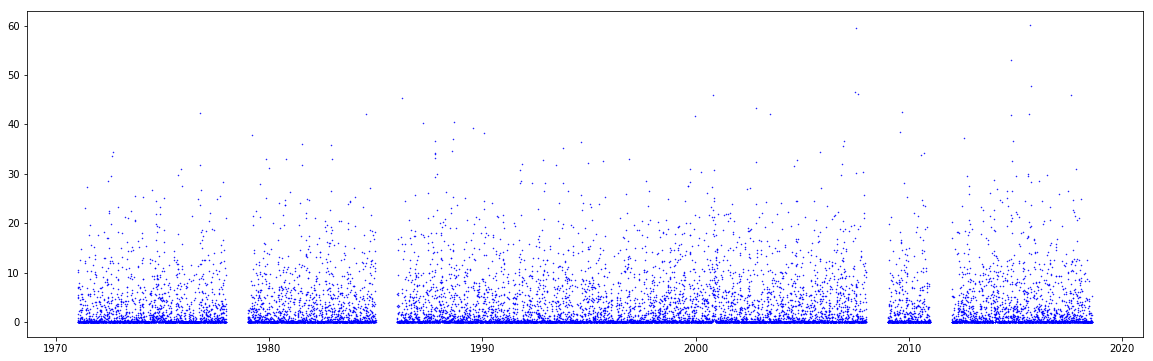

In [45]:
nc_file='./rain.nc4'
nc_data = xr.open_dataset(nc_file)
time = nc_data.time.values
rainData =  nc_data.RR.values
nc_data.close()

weightArray = np.array([i[1] for i in weights]).reshape(rainData.shape[1],rainData.shape[2])
totalWeight=np.nansum(weightArray)


basinRain = rainData[...,:,:] * weightArray / totalWeight;
basinRain = np.nansum(basinRain,axis=(1,2))
rain_df = pd.DataFrame({'precipitation(mm)':basinRain},index=time)
rain_df.to_pickle('./rain_vansjo.pickle')

plt.figure(figsize = (20,6))
plt.plot(time,basinRain,'b.',markersize=1)
